In [1]:
import sys
sys.path.insert(0,'/home/olgan96/.env/lib/python3.11/site-packages/')
from tqdm import tqdm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/home/olgan96/.env/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def drug_response_curve(x, Einf, EC50, HS, E0=100):
    y = Einf + (E0 - Einf)/(1 + (x/EC50)**HS)
    return y

In [4]:
def calc_responses(df, dose):
    Einf = df['Einf'].values
    EC50 = df['EC50'].values
    HS = df['HS'].values
    n_curves = df.shape[0]
    #r2 = np.zeros(len(dose_response))
    responses_pred = np.zeros(n_curves)
    for i in range(n_curves):
        responses_pred[i] = drug_response_curve(dose, Einf[i], EC50[i], HS[i]).item()
    return responses_pred

In [5]:
df_resp = pd.read_parquet('../../NO_BACKUP/tahoe/drug_response_curves.parquet')

In [6]:
resp_test = df_resp['dose_response'].values
resp_test_ = []
for i in range(len(resp_test)):
    for j in range(len(resp_test[i])):
        resp_test_.append(resp_test[i][j]['response'])

In [7]:
df_sig = pd.read_parquet('../../NO_BACKUP/tahoe/sig_overlap.parquet')

In [9]:
df_sig

,cl_sm_dose,cell_line,drug,dose,pubchem_cid,cell_line_drug
0,CVCL_0023_APTO-253_0.05,CVCL_0023,APTO-253,0.05,11960271,CVCL_0023_11960271
1,CVCL_0023_AZD-7648_0.05,CVCL_0023,AZD-7648,0.05,135151360,CVCL_0023_135151360
2,CVCL_0023_AZD-8055_0.05,CVCL_0023,AZD-8055,0.05,25262965,CVCL_0023_25262965
3,CVCL_0023_AZD1390_0.05,CVCL_0023,AZD1390,0.05,126689157,CVCL_0023_126689157
4,CVCL_0023_Afatinib_0.05,CVCL_0023,Afatinib,0.05,10184653,CVCL_0023_10184653
...,...,...,...,...,...,...
8000,CVCL_1731_Sunitinib_0.5,CVCL_1731,Sunitinib,0.5,5329102,CVCL_1731_5329102
8001,CVCL_1731_Trametinib_0.5,CVCL_1731,Trametinib,0.5,11707110,CVCL_1731_11707110
8002,CVCL_1731_Uridine_0.5,CVCL_1731,Uridine,0.5,6029,CVCL_1731_6029
8003,CVCL_1731_Vandetanib_0.5,CVCL_1731,Vandetanib,0.5,3081361,CVCL_1731_3081361


In [10]:
df_sig = df_sig[df_sig['cell_line_drug'].isin(df_resp['cell_line_drug'])].reset_index()

In [13]:
df_sig['dose'] = df_sig['dose'].astype(float)

In [14]:
doses = df_sig['dose'].values
cell_drugs = df_sig['cell_line_drug'].values
responses = []
for i in tqdm(range(len(cell_drugs))):
    cell_drug = cell_drugs[i]
    df = df_resp[df_resp['cell_line_drug'] == cell_drug].reset_index().copy()
    responses.append(np.array(calc_responses(df, doses[i])).mean().item())
    #if len(responses[-1]) == 0:
    #    break

100%|██████████| 4386/4386 [00:21<00:00, 199.72it/s]


In [15]:
df_sig['responses'] = responses

(array([ 175.,  239.,  258.,  249.,  267.,  239.,  247.,  255.,  341.,
        2116.]),
 array([2.47152167e-07, 1.00000002e+01, 2.00000002e+01, 3.00000002e+01,
        4.00000001e+01, 5.00000001e+01, 6.00000001e+01, 7.00000001e+01,
        8.00000000e+01, 9.00000000e+01, 1.00000000e+02]),
 <BarContainer object of 10 artists>)

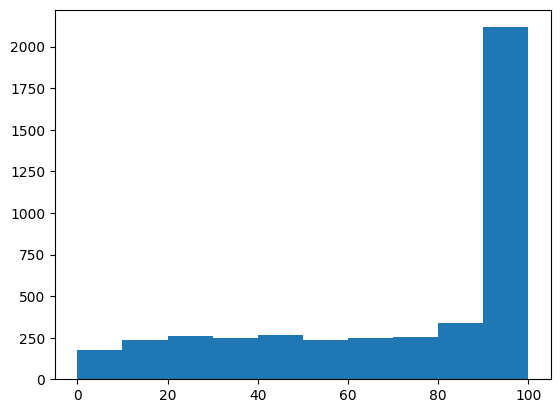

In [16]:
plt.hist(df_sig['responses'])

(array([2.0000e+00, 1.9000e+01, 1.7700e+03, 7.8290e+03, 1.3791e+04,
        1.9617e+04, 1.9722e+04, 2.0135e+04, 2.0782e+04, 3.0953e+04]),
 array([-36.5183    , -22.8668926 ,  -9.21548521,   4.43592219,
         18.08732958,  31.73873698,  45.39014438,  59.04155177,
         72.69295917,  86.34436656,  99.99577396]),
 <BarContainer object of 10 artists>)

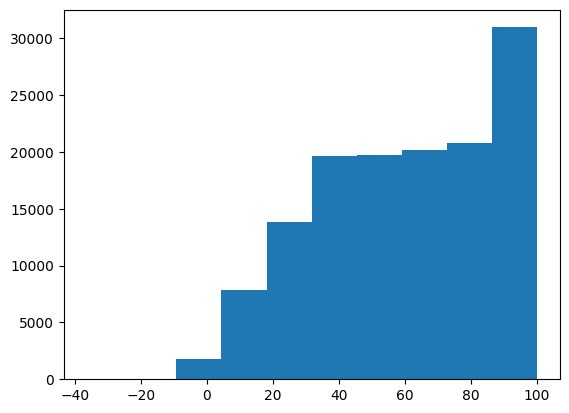

In [17]:
plt.hist(np.array(resp_test_)[np.array(resp_test_)<100])

(array([1.08828585e-06, 1.03387156e-05, 9.63132976e-04, 4.26009496e-03,
        7.50427507e-03, 1.06744517e-02, 1.07315868e-02, 1.09563178e-02,
        1.13083783e-02, 1.68428559e-02]),
 array([-36.5183    , -22.8668926 ,  -9.21548521,   4.43592219,
         18.08732958,  31.73873698,  45.39014438,  59.04155177,
         72.69295917,  86.34436656,  99.99577396]),
 <BarContainer object of 10 artists>)

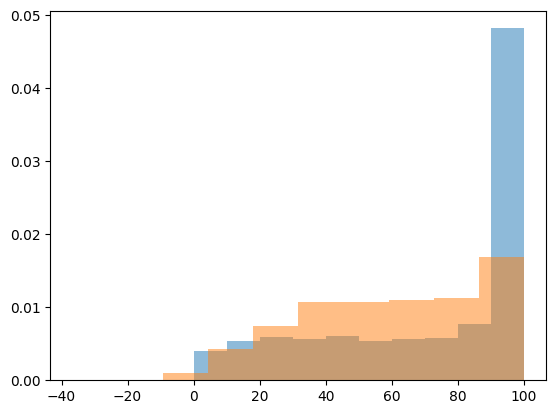

In [18]:
plt.hist(df_sig['responses'], density=True, alpha=0.5)
plt.hist(np.array(resp_test_)[np.array(resp_test_)<100], density=True, alpha=0.5)

In [19]:
df_sig['responses'] = df_sig['responses']/100

In [20]:
df_sig

,index,cl_sm_dose,cell_line,drug,dose,pubchem_cid,cell_line_drug,responses
0,0,CVCL_0023_APTO-253_0.05,CVCL_0023,APTO-253,0.05,11960271,CVCL_0023_11960271,0.989992
1,1,CVCL_0023_AZD-7648_0.05,CVCL_0023,AZD-7648,0.05,135151360,CVCL_0023_135151360,0.991688
2,2,CVCL_0023_AZD-8055_0.05,CVCL_0023,AZD-8055,0.05,25262965,CVCL_0023_25262965,0.689011
3,3,CVCL_0023_AZD1390_0.05,CVCL_0023,AZD1390,0.05,126689157,CVCL_0023_126689157,0.999031
4,4,CVCL_0023_Afatinib_0.05,CVCL_0023,Afatinib,0.05,10184653,CVCL_0023_10184653,0.912780
...,...,...,...,...,...,...,...,...
4381,7978,CVCL_1731_5-Fluorouracil_0.5,CVCL_1731,5-Fluorouracil,0.50,3385,CVCL_1731_3385,0.923447
4382,7981,CVCL_1731_Belinostat_0.5,CVCL_1731,Belinostat,0.50,6918638,CVCL_1731_6918638,0.912687
4383,7990,CVCL_1731_Fulvestrant_0.5,CVCL_1731,Fulvestrant,0.50,104741,CVCL_1731_104741,0.901148
4384,7997,CVCL_1731_Panobinostat_0.5,CVCL_1731,Panobinostat,0.50,6918837,CVCL_1731_6918837,0.470417


In [21]:
df_sig.to_parquet('../../NO_BACKUP/tahoe/signature_response.parquet', index=False)